In [1]:
from torch.autograd import Variable

In [65]:
import PIL
from PIL import Image

import scipy.misc
import numpy as np
from sklearn import cluster

In [3]:
from _model import ConvAutoencoder, skip, collect_feature_maps
from _utils import *

In [4]:
from net import skip  # code migratred from DoubleDIP

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

### Load chosen image 

In [550]:
image_name = 'man'

In [551]:
input_path = '../double_dip/images/{}.jpg'.format(image_name)

img_pil = Image.open(input_path)
img_pil = crop_image_by_multiplier(img_pil, d=32)

img_np = pil_to_np(img_pil)
img_np.shape

(3, 160, 256)

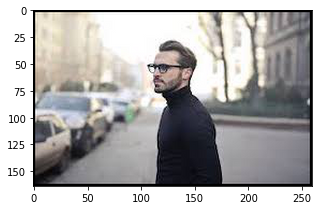

In [552]:
plot_image_grid([img_np], factor=4);

### Load model 

In [553]:
device = 'cpu'

In [554]:
model = skip(
    3, 3,
    num_channels_down=[8, 16, 32],
    num_channels_up=[8, 16, 32],
    num_channels_skip=[0, 0, 0],
    upsample_mode='bilinear',
    filter_size_down=3,
    filter_size_up=3,
    need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU').to(device)

### Define optimization 

In [555]:
learning_rate = 1e-3
mse_loss = nn.L1Loss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=1e-5)

### Train model for several epochs 

In [556]:
num_iter = 50

In [557]:
model.train()

X = torch.from_numpy(img_np).unsqueeze(0)
X = Variable(X)

learning_curve = []
recon_curve = [torch_to_np(X)]

for epoch in range(num_iter):

    X_rec = model(X)  # inference
    
    loss = mse_loss(X_rec, X)
    learning_curve.append(loss)
    
    if epoch % 50 == 0:
        print("epoch:: {}, LOSS = {}".format(epoch + 1, loss))
        if epoch >= 10:
            recon_curve.append(torch_to_np(X_rec))
    
    loss.backward()
    optimizer.step()
    model.zero_grad()

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:: 1, LOSS = 0.2503061890602112


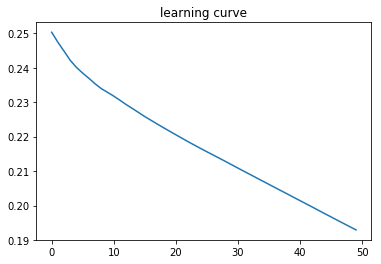

In [558]:
plt.plot(learning_curve);
plt.title('learning curve');

##### Save learned prior 

In [559]:
image = np_to_pil(torch_to_np(X_rec))
image.save('../double_dip/priors/{}_prior.jpg'.format(image_name))

### Visualize reconstruction

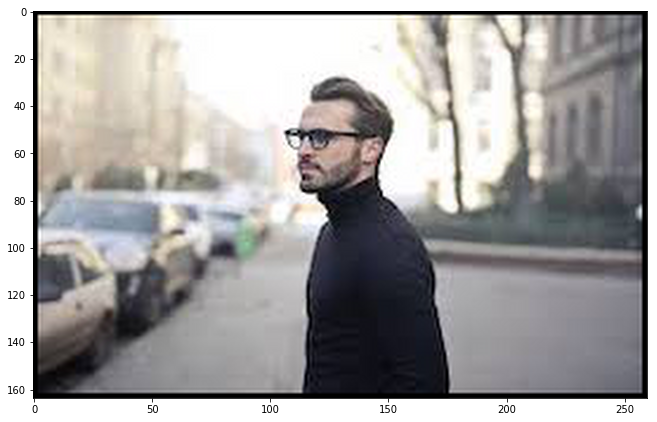

In [560]:
plot_image_grid(recon_curve, factor=10);

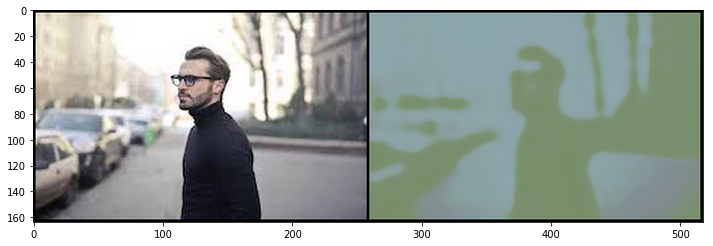

In [561]:
plot_image_grid([torch_to_np(X), torch_to_np(X_rec)], factor=10);

### Segment the Image (using KMeans)

In [562]:
def pixel_cluster_to_image_array(pixel_cluster, n, m):
    
    image_arr = pixel_cluster.transpose().reshape(1, n, m)
    return image_arr

In [563]:
prior_result = torch_to_np(X_rec)

In [564]:
_, n, m = prior_result.shape

In [565]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(prior_result.reshape(3, n * m).transpose())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [566]:
pixel_cluster = kmeans.predict(prior_result.reshape(3, n * m).transpose())
pixel_cluster.shape

(40960,)

In [567]:
cluster_image_arr = pixel_cluster_to_image_array(pixel_cluster, n, m)

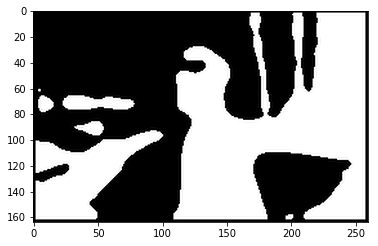

In [568]:
plot_image_grid([cluster_image_arr], factor=5);

In [569]:
image = np_to_pil(cluster_image_arr)
image.save('../double_dip/saliency/output_scaled/{}_cluster_hint.jpg'.format(image_name))